# Discussion 8️⃣: Logistic regression
Josh Grossman

<img src="img/logistic-meme-1.jpeg" alt= "most-interesting-man" width="250" /> <img src="img/logistic-meme-2.jpeg" alt= "predicting-0.5" width="300" />

Welcome to the eighth (and final 😭) discussion of MS&E 125!

In this notebook, we'll discuss logistic regression.

Logistic regression is widely used in industry as the de facto model for
classifying a binary outcome.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import statsmodels.formula.api as smf
import statsmodels.api as sm

## 🧗 Introduction

Suppose we survey 100 people and generate a two-column dataset:
1. The first column is a binary indicator (0/1) of whether the person is feeling generally happy 😃 or sad 🙁.
2. The second column is a 1-100 index of how ☀️sunny☀️ it was outside the day the person was surveyed. 

Here's the data:

<AxesSubplot: xlabel='sun_index', ylabel='happy'>

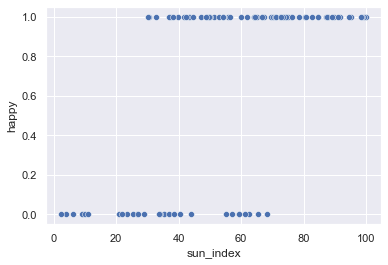

In [9]:
# set seed
np.random.seed(125)

# vector of 30 0's and 70 1's
happy = np.concatenate((np.zeros(30), np.ones(70)))

# vector of 30 random numbers from 50 to 100, and 70 random numbers from 0 to 50
sun_index = np.concatenate((np.random.uniform(0, 70, 70), np.random.uniform(30, 100, 30)))

# create dataframe
df = pd.DataFrame({'happy': happy, 'sun_index': sun_index})

# plot the data
sns.scatterplot(data=df, x='sun_index', y='happy')

We can construct a linear regression using this data:

<AxesSubplot: xlabel='sun_index', ylabel='happy'>

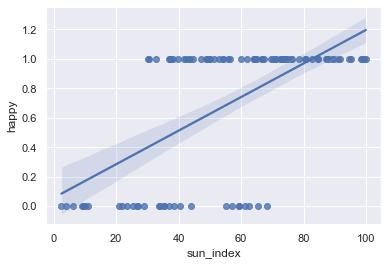

In [46]:
# plot a linear model with the data
sns.regplot(data=df, x='sun_index', y='happy')

As you might expect, it looks like people are generally happier when it's sunnier. 

But, there's a big problem 🙀! The true outcome is binary valued (i.e., 0 or 1), yet the model predicts values not just between 0 and 1, but from negative infinity to positive infinity!

Wouldn't it be nice if we could transform the $(-\infty,+\infty)$ outcome space of linear regression to something on the $[0,1]$ scale?

## 🗺️ Mapping numeric inputs

Suppose we have an array of probabilities between 0 and 1:

In [23]:
# generate 1000 values between 0 and 1
probs = np.random.uniform(0, 1, 1000)
print(probs.min())
print(probs.max())

0.001707034900044313
0.9991686426046572


If we were to take the logarithm of these values, we'd get a new array of values
between $-\infty$ and 0:

Text(0, 0.5, 'Log Probability')

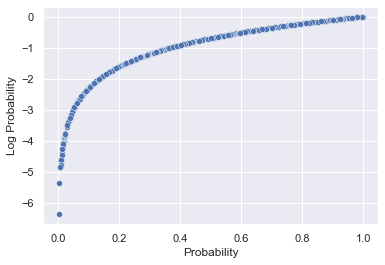

In [28]:
log_probs = np.log(probs)

sns.scatterplot(x=probs, y=log_probs)
plt.xlabel('Probability')
plt.ylabel('Log Probability')

In other words, we can say that the $\log$ function maps $[0, 1]$ to $(-\infty, 0]$.

### 🏋️ Exercise

If I have an array of numbers on $(0, +\infty)$ and I apply the $\log$ function,
what is the range of the resulting array?

*Answer*: the output range is $(-\infty, \infty)$.

## Odds

Odds are defined as the probability of an event divided by the probability of the complement.

For example, if I have a 90% chance of winning a prize, my odds of winning are $0.9/(1-0.9)=9$.

Here's a visual:

Text(0, 0.5, 'Odds')

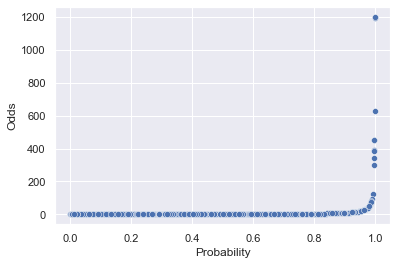

In [33]:
def odds(p):
    return p / (1 - p)

odds_of_probs = odds(probs)

sns.scatterplot(x=probs, y=odds_of_probs)
plt.xlabel('Probability')
plt.ylabel('Odds')

### 🏋️ Exercise

What are the minimum possible odds for any event? The maximum odds?

*Answer*: The range for odds is $(0, \infty)$.

### 🪵 Log odds

Starting with a probability value on $[0,1]$, we can apply the odds function to
map the probability to $[0,+\infty]$, and then apply the $\log$ function to 
map the output to $[-\infty,+\infty]$.

Thus the log-odds function allows us to map $[0,1]$ to $[-\infty,+\infty]$:

Text(0, 0.5, 'Log Odds')

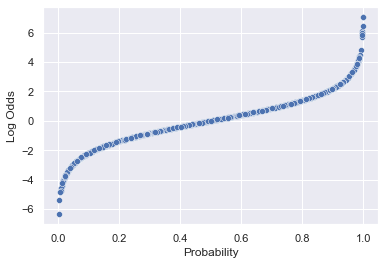

In [34]:
def log_odds(p):
    return np.log(odds(p))

log_odds_of_probs = log_odds(probs)

sns.scatterplot(x=probs, y=log_odds_of_probs)
plt.xlabel('Probability')
plt.ylabel('Log Odds')

But, our original problem was that linear regression outputs values on 
$[-\infty,+\infty]$, yet we want outputs on $[0,1]$!

### 🏋️ Exercise (in algebra!)

Derive the inverse of the log-odds (i.e., logit) function:

\begin{align}

\text{logit}(p) = \text{log-odds}(p) = \log \left( \text{odds}(p) \right) = \log \frac{p}{1-p}

\end{align}

### 

*Answer*: 

\begin{align*}
x &= \log\frac{p}{1 - p} \\
\exp(x) &= \frac{p}{1-p} \\
(1 - p) \exp(x) &= p \\
\exp(x) - p\exp(x) &= p \\
\exp(x) &= p + p\exp(x) \\
\exp(x) &= p(1 + \exp(x)) \\
p &= \frac{\exp(x)}{1 + \exp(x)} = \frac{1}{\frac{1}{\exp(x)} + \frac{\exp(x)}{\exp(x)}} = \frac{1}{1 + \exp(-x)}
\end{align*}

### ♻️ The inverse logit function

The inverse logit function (i.e., the expit function), has the following form:

\begin{align*}
  \text{logit}^{-1}(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}}
\end{align*}

The inverse logit function solves our original problem: it maps $[-\infty,+\infty]$ to $[0,1]$!

Text(0, 0.5, 'Probability')

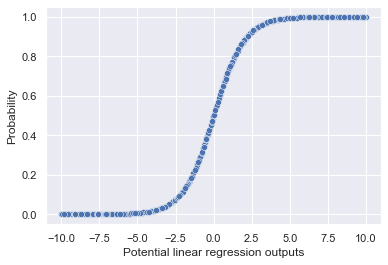

In [45]:
def logit_inverse(x):
    return 1 / (1 + np.exp(-x))

potential_linear_regression_outcomes = np.random.uniform(-10,10, 1000)

logit_inverse_of_outcomes = logit_inverse(potential_linear_regression_outcomes)

sns.scatterplot(x=potential_linear_regression_outcomes, y=logit_inverse_of_outcomes)
plt.xlabel('Potential linear regression outputs')
plt.ylabel('Probability')

## 🚶 Simple logistic regression

Let's return to our original linear regression:

<AxesSubplot: xlabel='sun_index', ylabel='happy'>

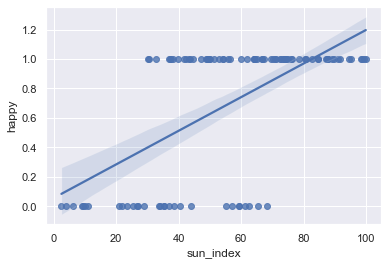

In [47]:
sns.regplot(data=df, x='sun_index', y='happy')

This fitted linear regression model takes on the following form:

\begin{align*}
  \widehat{\text{happy}} = \hat{\beta}_0 + \hat{\beta}_1 * \text{sun\_index}
\end{align*}

If we were to plug in any value in $[-\infty,+\infty]$ to $\text{sun\_index}$ 
on the right side of the regression equation, we'd have a 
fitted model output that's also in $[-\infty,+\infty]$.

But, if we were to construct a model of the following form, our output would
be guaranteed to fall in $[0,1]$, since the inverse logit function
maps $[-\infty,+\infty]$ to $[0,1]$:

\begin{align*}
  \Pr (\text{happy}=1) = \text{logit}^{-1} \left( \hat{\beta}_0 + \hat{\beta}_1 * \text{sun\_index} \right)
\end{align*}

The logistic regression algorithm finds values of $\hat{\beta}_0$ and 
$\hat{\beta}_1$ that best fit the data given the model above:

<AxesSubplot: xlabel='sun_index', ylabel='happy'>

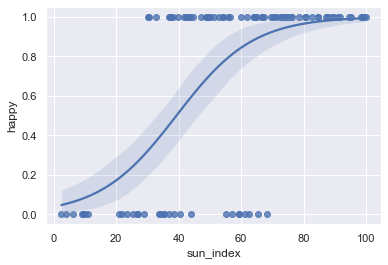

In [48]:
# plot a logistic regression model
sns.regplot(data=df, x='sun_index', y='happy', logistic=True)

A few things to note:
- Unlike the linear regression algorithm, the logistic regression algorithm 
does not have a closed form. In other words, an optimization algorithm is
used "under the hood" to find $\hat{\beta}$ values that are most consistent 
with the data.
- The linear regression model looks a lot like the logistic regression model
towards the middle of the plot! Linear regression still does a surprisingly good
job. This kind of linear regression model is known as a **linear probability model**.

## 🤔 Interpreting logistic regression coefficients

It's helpful to remember that the logistic regression model is identical
to the model below:

\begin{align*}
  \text{logit} \left( \Pr (\text{happy}=1) \right) = \hat{\beta}_0 + \hat{\beta}_1 * \text{sun\_index}
\end{align*}

Using this framing, we can interpret logistic regression coefficients exactly
the same way as linear regression coefficients, but we have to be mindful of
the new outcome, which is the log-odds of the probability of the event
$\text{happy}=1$.

1. $\hat{\beta}_0$ is the predicted value of the outcome when 
$\text{sun\_index}=0$, just like linear regression!

> $\hat{\beta}_0$ is, equivalently, the predicted log-odds that 
$\text{happy}=1$ when $\text{sun\_index}=0$.


1. $\hat{\beta}_1$ is the predicted increase in the outcome when 
$\text{sun\_index}$ goes up by 1, just like linear regression!

> $\hat{\beta}_1$ is, equivalently, the predicted increase in log-odds of the event 
$\text{happy}=1$ when $\text{sun\_index}$ goes up by 1.

Additional slope terms, quadratic terms, and interaction terms are all 
interpreted exactly the same way as linear regression, just be mindful 
of the new outcome!

### 🏋️ Exercise

Using the definitions above, interpret the intercept and slope coefficients
of the logistic regression output below.


In [51]:
# fit a logistic regression model
logistic_model = smf.logit(formula='happy ~ sun_index', data=df).fit()

# print the model summary
print(logistic_model.summary())


Optimization terminated successfully.
         Current function value: 0.392862
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  happy   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 May 2023   Pseudo R-squ.:                  0.3569
Time:                        22:25:35   Log-Likelihood:                -39.286
converged:                       True   LL-Null:                       -61.086
Covariance Type:            nonrobust   LLR p-value:                 4.027e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1959      0.828     -3.859      0.000      -4.819      -1.573
sun_index      0.0813      0.

*Answer*:

- Slope: For each unit increase in sun index, the predicted log odds of being happy increases by 0.08.
- Intercept: When sun index is 0, the predicted log odds of being happy is -3.20.

## 🧨 Exponentiating logistic regression coefficients

Let's be real: who thinks in log-odds? It's much easier to think about the world in odds!

Let's exponentiate both sides of our model:

\begin{align*}
  \text{logit} \left( \Pr (\text{happy}=1) \right) & = \hat{\beta}_0 + \hat{\beta}_1 * \text{sun\_index} \\
  \text{log-odds} \left( \Pr (\text{happy}=1) \right) & = \hat{\beta}_0 + \hat{\beta}_1 * \text{sun\_index} \\
  \exp \left( \text{log-odds} \left( \Pr (\text{happy}=1) \right) \right) & = \exp \left( \hat{\beta}_0 + \hat{\beta}_1 * \text{sun\_index} \right) \\

  \text{odds} \left( \Pr (\text{happy}=1) \right) & = \exp \left( \hat{\beta}_0 \right) * \exp \left( \hat{\beta}_1 * \text{sun\_index} \right) \\
\end{align*}

Our new and improved interpretations:

1. $\exp \left( \hat{\beta}_0 \right)$ is the predicted **odds** that 
$\text{happy}=1$ when $\text{sun\_index}=0$.


2. $\exp \left( \hat{\beta}_1 \right)$ is the predicted **muliplicative increase in odds** of the event
$\text{happy}=1$ when $\text{sun\_index}$ goes up by 1.

### 🏋️ Exercise

Using the definitions above, interpret the exponentiated intercept and slope 
coefficients of the logistic regression model.

In [56]:
# print original coefficients
print(logistic_model.params)

# print exponentiated coefficients
print(np.exp(logistic_model.params))

Intercept   -3.195854
sun_index    0.081299
dtype: float64
Intercept    0.040932
sun_index    1.084695
dtype: float64


*Answer*: 

- Slope: for each unit increase in sun index, the predicted odds for being happy is multiplied by an addition $e^{0.08}$.
- Intercept: when sun index is 0, the predicted odds for being happy is $e^{-3.20}$.